**<h2 style="text-align: center; color:#33FF33;">CHURN CLASSIFY WITH PURCHASE USERS</h2>**

#### **Neccessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics  import mutual_info_score
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.ensemble import VotingClassifier,StackingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, brier_score_loss,classification_report,
    confusion_matrix, roc_curve, auc, brier_score_loss
)
import warnings

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

### **Read and explore data**

#### **Read data**

In [2]:
df_login=pd.read_csv("../EDA_transform/data/login_transform.csv",dtype={'vopenid':'object'},parse_dates=['last_update_time'])
df_purchase=pd.read_csv("../EDA_transform/data/purchase_transform.csv",dtype={'vopenid':'object'})
df_equip=pd.read_csv("../EDA_transform/data/equipenhance_transform_cluster.csv",dtype={'vopenid':'object'})
df_regis=pd.read_csv("../EDA_transform/data/register_transform.csv",dtype={'vopenid':'object'})

df_purchase.columns = df_purchase.columns.str.strip()
df_equip.columns = df_equip.columns.str.strip()
df_purchase['last_update_time'] = pd.to_datetime(df_purchase['last_update_time'], errors='coerce', utc=True)
df_equip['last_update_time'] = pd.to_datetime(df_equip['last_update_time'], errors='coerce', utc=True)

df_login.shape,df_purchase.shape,df_equip.shape

((201416, 25), (37219, 11), (55138, 7))

In [3]:
df_login.info(),df_login['last_update_time'].min(),df_login['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201416 entries, 0 to 201415
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   vopenid                201416 non-null  object             
 1   last_update_time       201416 non-null  datetime64[ns, UTC]
 2   num_login              201416 non-null  int64              
 3   num_day_login          201416 non-null  int64              
 4   login_frequency        201416 non-null  float64            
 5   avg_weekly_login       201416 non-null  float64            
 6   std_weekly_login       201416 non-null  float64            
 7   streak_login           201416 non-null  int64              
 8   days_since_last_login  201416 non-null  int64              
 9   popular_time_login     201416 non-null  int64              
 10  gold_std_login         201416 non-null  float64            
 11  diamond_std_login      201416 non-null 

(None,
 Timestamp('2025-05-03 16:08:43+0000', tz='UTC'),
 Timestamp('2025-06-19 23:59:59+0000', tz='UTC'))

In [4]:
df_purchase.info(),df_purchase['last_update_time'].min(),df_purchase['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37219 entries, 0 to 37218
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   vopenid                   37219 non-null  object             
 1   last_update_time          37167 non-null  datetime64[ns, UTC]
 2   total_purchase            37219 non-null  float64            
 3   num_purchase              37219 non-null  int64              
 4   max_purchase              37219 non-null  float64            
 5   avg_purchase              37219 non-null  float64            
 6   frequency_purchase        37219 non-null  float64            
 7   count_purchase_on_day     37219 non-null  float64            
 8   std_amount_purchase       37219 non-null  float64            
 9   days_since_last_purchase  37219 non-null  int64              
 10  num_product_buyed         37219 non-null  int64              
dtypes: datetime64[n

(None,
 Timestamp('2025-05-01 00:07:24.302000+0000', tz='UTC'),
 Timestamp('2025-06-25 23:59:55.587000+0000', tz='UTC'))

In [5]:
df_equip.info(),df_equip['last_update_time'].min(),df_equip['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55138 entries, 0 to 55137
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   vopenid                   55138 non-null  object             
 1   last_update_time          55138 non-null  datetime64[ns, UTC]
 2   total_attempts            55138 non-null  int64              
 3   total_success_wt          55138 non-null  int64              
 4   equipenhance_lucky        55138 non-null  float64            
 5   max_consecutive_failures  55138 non-null  int64              
 6   equi_beha                 55138 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(2)
memory usage: 2.9+ MB


(None,
 Timestamp('2025-05-03 17:00:34+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:58+0000', tz='UTC'))

In [6]:
df_regis.info(),df_regis['last_update_time'].min(),df_regis['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99270 entries, 0 to 99269
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   vopenid              99270 non-null  object
 1   last_update_time     99270 non-null  object
 2   days_since_register  99270 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


(None, '2025-05-01 00:00:28.354000+00:00', '2025-06-18 23:59:59.461000+00:00')

#### **Merge data**

In [7]:
df_login = df_login.rename(columns={'last_update_time': 'last_update_time_login'})
df_purchase = df_purchase.rename(columns={'last_update_time': 'last_update_time_purchase'})
df_equip = df_equip.rename(columns={'last_update_time': 'last_update_time_equip'})

df_purchase_user = df_purchase.copy()

df_merged = df_purchase_user.merge(
    df_login, 
    on='vopenid',
    how='inner'
)
df_merged = df_merged.merge(
    df_equip[['vopenid', 'equi_beha']],
    on='vopenid',
    how='left'
)

In [8]:
del df_login
del df_purchase
del df_equip

In [9]:
df_merged=df_merged[df_merged['num_day_login'] >= 1].reset_index(drop=True)
df_merged.shape

(36125, 36)

In [10]:
# print("Before filter:", df_merged.shape)
# print("Regis count:", df_regis['vopenid'].nunique())

# print("Match count:", df_merged['vopenid'].isin(df_regis['vopenid']).sum())


In [11]:
# df_merged = df_merged[df_merged['vopenid'].isin(df_regis['vopenid'])].reset_index(drop=True)
# df_merged.shape

In [12]:
df_merged.head(3)

,vopenid,last_update_time_purchase,total_purchase,num_purchase,max_purchase,avg_purchase,frequency_purchase,count_purchase_on_day,std_amount_purchase,days_since_last_purchase,num_product_buyed,last_update_time_login,num_login,num_day_login,login_frequency,avg_weekly_login,std_weekly_login,streak_login,days_since_last_login,popular_time_login,gold_std_login,diamond_std_login,silkcoin_std_login,gold_slope_login,diamond_slope_login,silkcoin_slope_login,short_lifetime_flag,powerpoint_last_login,level_last_login,vip_last_login,duration,event,first_login,last_login,churn,equi_beha
0,2206211830166192,2025-05-24 15:48:36.757000+00:00,0.79,1,0.79,0.79,1.00,1.00,0.00,32,1,2025-05-26 03:29:48+00:00,15,3,5.00,15.00,6.50,3,24,9,181008.90,0.00,4.79,34524.61,0.00,0.81,0,265807,28,0,3,1,2025-05-24,2025-05-26,1,NaN
1,2208132058338497,2025-06-20 03:06:03.875000+00:00,1.99,1,1.99,1.99,1.00,1.00,0.00,6,1,2025-06-19 17:28:13+00:00,3,2,1.50,3.00,0.50,1,0,7,224679.32,0.00,19.05,-194578.00,0.00,-16.50,1,25482,1,0,5,1,2025-06-15,2025-06-19,0,NaN
2,2210221534402190,2025-05-26 05:14:28.541000+00:00,7.88,1,7.88,7.88,1.00,1.00,0.00,31,1,2025-06-19 23:44:18+00:00,313,47,6.66,44.71,17.54,47,0,23,1405101.67,20.28,46.89,-3603.13,-0.16,0.09,0,20972875,78,3,47,1,2025-05-04,2025-06-19,0,a


In [13]:
df_merged['equi_beha'] = df_merged['equi_beha'].fillna('not_enhance')

In [14]:
# df_merged['vopenid'] = df_merged['vopenid'].astype(str) + "_" + df_merged["id_win"].astype(str)

In [15]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36125 entries, 0 to 36124
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   vopenid                    36125 non-null  object             
 1   last_update_time_purchase  36075 non-null  datetime64[ns, UTC]
 2   total_purchase             36125 non-null  float64            
 3   num_purchase               36125 non-null  int64              
 4   max_purchase               36125 non-null  float64            
 5   avg_purchase               36125 non-null  float64            
 6   frequency_purchase         36125 non-null  float64            
 7   count_purchase_on_day      36125 non-null  float64            
 8   std_amount_purchase        36125 non-null  float64            
 9   days_since_last_purchase   36125 non-null  int64              
 10  num_product_buyed          36125 non-null  int64              
 11  la

#### **Set churn**

In [16]:
now = pd.Timestamp('2025-06-26 23:00:00', tz='UTC')
df_merged['days_since_last_login'] = (now - df_merged['last_update_time_login']).dt.days

In [17]:
# df_merged['last_update_time_login'].min(),df_merged['last_update_time_login'].max()

In [18]:
# df_merged['churn'] = (df_merged['days_since_last_login'] > 7).astype(int) # true is one
# df_merged[['vopenid','last_update_time_login','churn']].head(20)

In [19]:
df_merged['churn'].value_counts()

churn
0    32144
1     3981
Name: count, dtype: int64

In [20]:
df_merged.columns

Index(['vopenid', 'last_update_time_purchase', 'total_purchase',
       'num_purchase', 'max_purchase', 'avg_purchase', 'frequency_purchase',
       'count_purchase_on_day', 'std_amount_purchase',
       'days_since_last_purchase', 'num_product_buyed',
       'last_update_time_login', 'num_login', 'num_day_login',
       'login_frequency', 'avg_weekly_login', 'std_weekly_login',
       'streak_login', 'days_since_last_login', 'popular_time_login',
       'gold_std_login', 'diamond_std_login', 'silkcoin_std_login',
       'gold_slope_login', 'diamond_slope_login', 'silkcoin_slope_login',
       'short_lifetime_flag', 'powerpoint_last_login', 'level_last_login',
       'vip_last_login', 'duration', 'event', 'first_login', 'last_login',
       'churn', 'equi_beha'],
      dtype='object')

#### **Visualize**

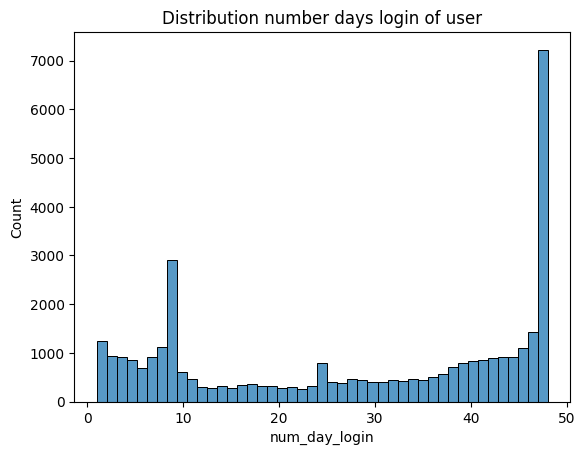

In [21]:
sns.histplot(df_merged['num_day_login'], bins=45)
plt.title('Distribution number days login of user')
plt.show()

In [22]:
df_merged['last_update_time_login'].min(),df_merged['last_update_time_login'].max()

(Timestamp('2025-05-04 05:47:05+0000', tz='UTC'),
 Timestamp('2025-06-19 23:59:59+0000', tz='UTC'))

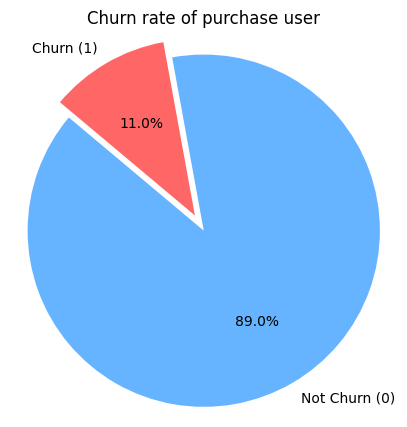

In [23]:
churn_counts = df_merged['churn'].value_counts().sort_index()
labels = ['Not Churn (0)', 'Churn (1)']
colors = ['#66b3ff', '#ff6666']

plt.figure(figsize=(5,5))
plt.pie(
    churn_counts, 
    labels=labels, 
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=[0, 0.1]  
)
plt.title("Churn rate of purchase user")
plt.axis('equal') 
plt.show()

In [24]:
drop_cols = [
    # 'last_update_time_purchase',
    # 'last_update_time_login',
    # 'days_since_last_purchase',
    'event',
    'duration',
    'first_login',
    'last_login',
    'gold_slope_login',
    'diamond_slope_login',
    'silkcoin_slope_login',
    'popular_time_login',
    'last_update_time_purchase',
    'last_update_time_login',
    # 'last_time_in_window',
    # 'event',
    # 'gold_first',
    # 'gold_last',
    # 'diamond_first',
    # 'diamond_last',
    # 'silkcoin_first',
    # 'silkcoin_last',
    # 'gold_max',
    # 'gold_min',
    # 'diamond_max',
    # 'diamond_min',
    # 'silkcoin_max',
    # 'silkcoin_min',
    'level_last_login',
]
df_merged=df_merged.drop(columns=drop_cols,axis=1)

In [25]:
df_merged.columns

Index(['vopenid', 'total_purchase', 'num_purchase', 'max_purchase',
       'avg_purchase', 'frequency_purchase', 'count_purchase_on_day',
       'std_amount_purchase', 'days_since_last_purchase', 'num_product_buyed',
       'num_login', 'num_day_login', 'login_frequency', 'avg_weekly_login',
       'std_weekly_login', 'streak_login', 'days_since_last_login',
       'gold_std_login', 'diamond_std_login', 'silkcoin_std_login',
       'short_lifetime_flag', 'powerpoint_last_login', 'vip_last_login',
       'churn', 'equi_beha'],
      dtype='object')

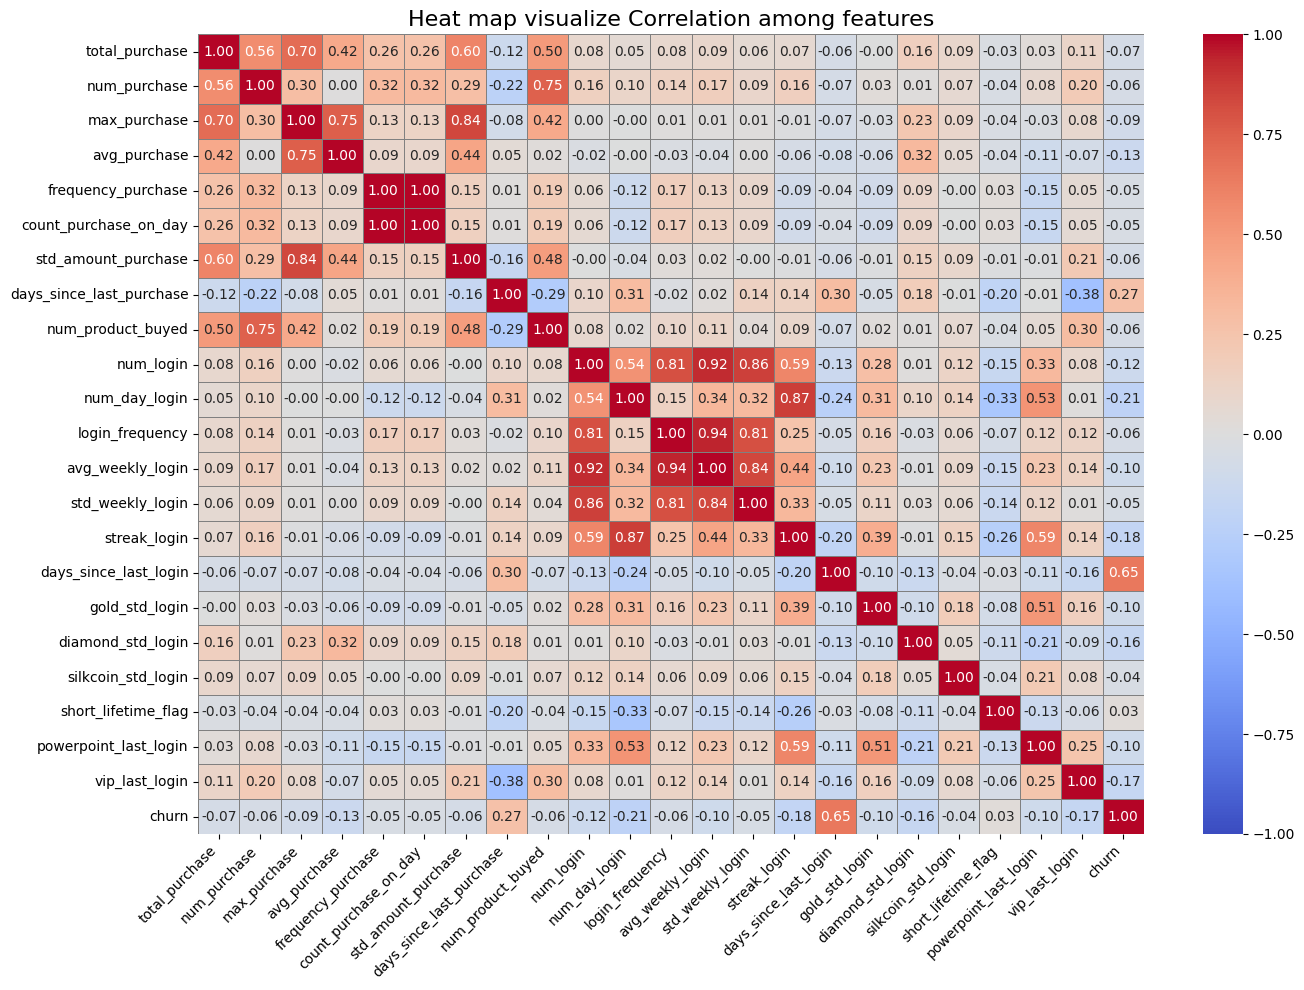

In [26]:
corr_cols = df_merged.drop(columns=['vopenid','equi_beha']).columns

corr_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=True,        
    fmt=".2f",
    cmap="coolwarm",    
    vmin=-1,           
    vmax=1,
    center=0,        
    linewidths=0.5,     
    linecolor='gray' 
)

plt.title('Heat map visualize Correlation among features', fontsize=16)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

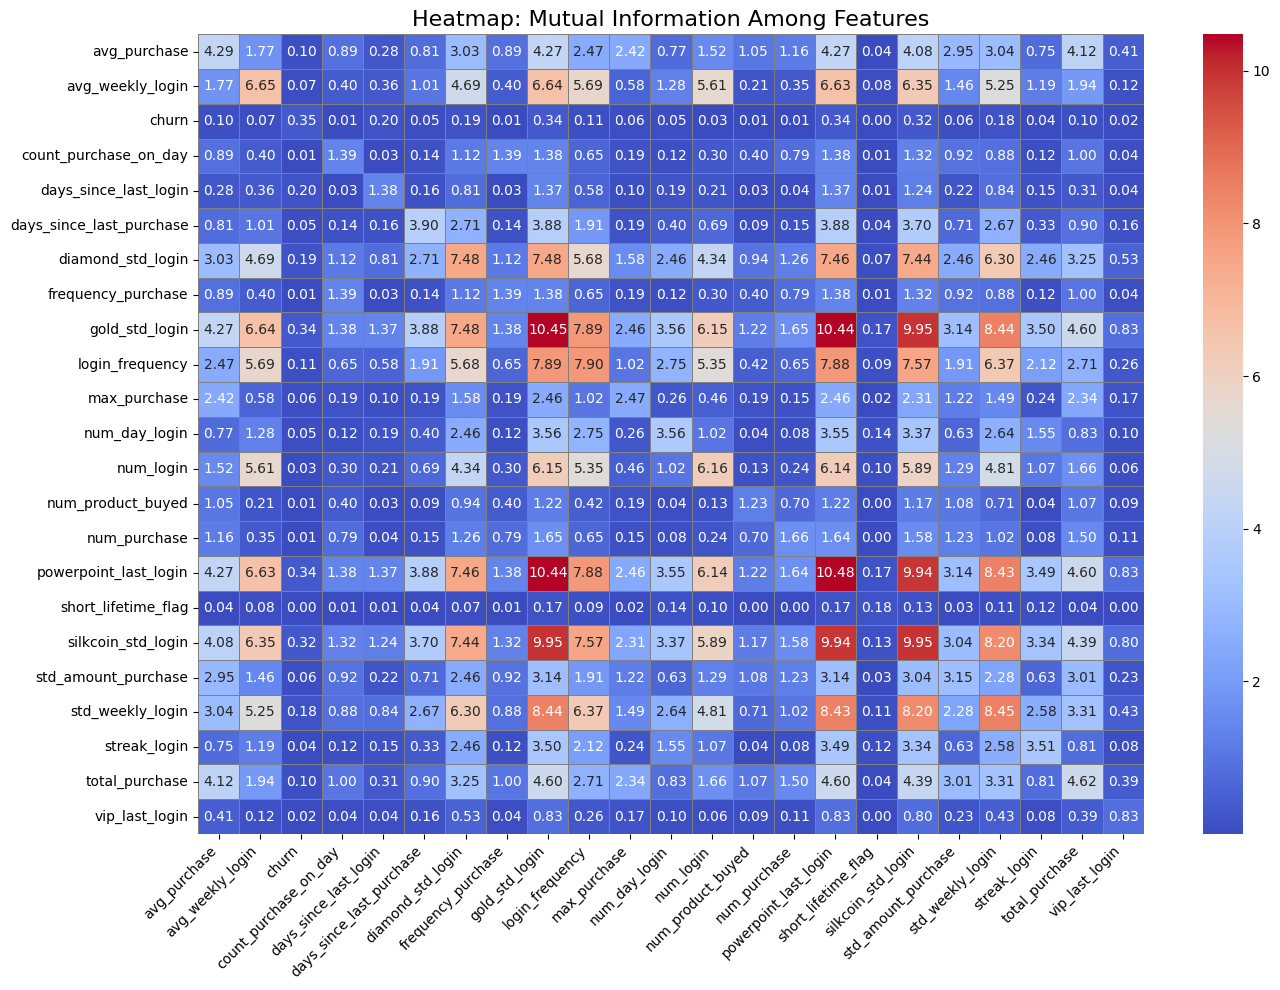

In [27]:
mi_cols = df_merged.columns.difference(['vopenid', 'equi_beha'])

mi_matrix = np.zeros((len(mi_cols), len(mi_cols)))
for i, f1 in enumerate(mi_cols):
    for j, f2 in enumerate(mi_cols):
        mi_matrix[i, j] = mutual_info_score(df_merged[f1], df_merged[f2])


plt.figure(figsize=(14, 10))
sns.heatmap(
    mi_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor='gray',
    xticklabels=mi_cols,
    yticklabels=mi_cols
)

plt.title('Heatmap: Mutual Information Among Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **Prepare data**

In [28]:
X=df_merged.drop(columns=['churn','vopenid','powerpoint_last_login','gold_std_login'],axis=1)
y=df_merged['churn']

In [29]:
vopenid_all = df_merged['vopenid']

In [30]:
le=LabelEncoder()
X['equi_beha']=le.fit_transform(X['equi_beha'])

In [31]:
X_train, X_test, y_train, y_test,vopenid_train, vopenid_test = train_test_split(
    X, y, vopenid_all,
    test_size=0.15,
    stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30706, 21), (5419, 21), (30706,), (5419,))

In [32]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [33]:
X_train_cb=X_train.copy()
y_train_cb=y_train.copy()
X_test_cb=X_test.copy()
y_test_cb=y_test.copy()
X_train_cb['equi_beha'] = X_train_cb['equi_beha'].astype(str)
X_test_cb['equi_beha'] = X_test_cb['equi_beha'].astype(str)

In [34]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [35]:
X_train.shape,y_train.shape, X_train_scaled.shape,X_test_scaled.shape

((54644, 21), (54644,), (54644, 21), (5419, 21))

### **Modeling**

#### **Logistic Regression**

In [36]:
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 0.001, 10.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced',None]),
        'random_state': 42
    }
    model = LogisticRegression(**params)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Best AUC:", study.best_value)
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-07-07 09:56:28,051] A new study created in memory with name: no-name-c50e5558-89b3-40b0-a543-8e93b7535c33
[I 2025-07-07 09:56:28,644] Trial 0 finished with value: 0.9659727838354177 and parameters: {'C': 9.244156972299875, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}. Best is trial 0 with value: 0.9659727838354177.
[I 2025-07-07 09:56:31,384] Trial 1 finished with value: 0.9628973558605617 and parameters: {'C': 0.007763585358642099, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9659727838354177.
[I 2025-07-07 09:56:31,647] Trial 2 finished with value: 0.957928914736998 and parameters: {'C': 0.0024073229770431265, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9659727838354177.
[I 2025-07-07 09:56:32,250] Trial 3 finished with value: 0.9659727637446098 and parameters: {'C': 8.493016142630943, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}. Best is t

Best AUC: 0.9659732593771189
  - C: 8.178169240873165
  - penalty: l1
  - solver: liblinear
  - class_weight: balanced


In [37]:
best_params_lr = study.best_params
best_params_lr.update({
    'random_state': 42,
    'n_jobs': -1
})
lr_model = LogisticRegression(**best_params_lr)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(C=8.178169240873165, class_weight='balanced', n_jobs=-1,
                   penalty='l1', random_state=42, solver='liblinear')

In [38]:
y_test_pred  = lr_model.predict(X_test_scaled)
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9269
Precision: 0.6252
Recall: 0.8409
F1-score: 0.7171
AUC-ROC: 0.9580
Log loss: 0.2716
Brier score: 0.0647

Confusion matrix:
[[4521  301]
 [  95  502]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4822
           1       0.63      0.84      0.72       597

    accuracy                           0.93      5419
   macro avg       0.80      0.89      0.84      5419
weighted avg       0.94      0.93      0.93      5419



#### **Extra Trees**

In [39]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 0.5, 0.8]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = ExtraTreesClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-07-07 09:59:40,889] A new study created in memory with name: no-name-4bb81c59-ebc7-43f8-b2b2-00d49554e2a7
[I 2025-07-07 09:59:45,943] Trial 0 finished with value: 0.9939557084130959 and parameters: {'n_estimators': 454, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9939557084130959.
[I 2025-07-07 09:59:49,886] Trial 1 finished with value: 0.9895905525792383 and parameters: {'n_estimators': 415, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 19, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9939557084130959.
[I 2025-07-07 09:59:53,763] Trial 2 finished with value: 0.9882008209525301 and parameters: {'n_estimators': 459, 'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'log2', 'class_weight': None}. Best is trial 0 with value: 0.9939557084130959.
[I 2025-07-07 10:00:01,108] Trial 3 finished with va

Best value: 0.9968429819094746
Best params:
  - n_estimators: 326
  - max_depth: 25
  - min_samples_split: 6
  - min_samples_leaf: 1
  - max_features: 0.5
  - class_weight: balanced


In [40]:
best_params_et = study.best_params
best_params_et.update({
    'random_state': 42,
    'n_jobs': -1
})
et_model = ExtraTreesClassifier(**best_params_et)
et_model.fit(X_train, y_train)

ExtraTreesClassifier(class_weight='balanced', max_depth=25, max_features=0.5,
                     min_samples_split=6, n_estimators=326, n_jobs=-1,
                     random_state=42)

In [41]:
y_test_pred  = et_model.predict(X_test)
y_test_proba = et_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9625
Precision: 0.8003
Recall: 0.8794
F1-score: 0.8380
AUC-ROC: 0.9842
Log loss: 0.1017
Brier score: 0.0290

Confusion matrix:
[[4691  131]
 [  72  525]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4822
           1       0.80      0.88      0.84       597

    accuracy                           0.96      5419
   macro avg       0.89      0.93      0.91      5419
weighted avg       0.96      0.96      0.96      5419



#### **Random Forest**

In [42]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500),            
        'max_depth': trial.suggest_int('max_depth', 10, 30),                     
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),     
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),      
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 0.5, 0.8]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced',None]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-07-07 10:03:33,724] A new study created in memory with name: no-name-5be5f73d-1859-467f-998d-20b605ada0ca
[I 2025-07-07 10:03:39,094] Trial 0 finished with value: 0.9935763802526745 and parameters: {'n_estimators': 391, 'max_depth': 16, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9935763802526745.
[I 2025-07-07 10:03:44,384] Trial 1 finished with value: 0.9942791661082836 and parameters: {'n_estimators': 363, 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9942791661082836.
[I 2025-07-07 10:04:14,964] Trial 2 finished with value: 0.9941970719437853 and parameters: {'n_estimators': 426, 'max_depth': 17, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9942791

Best value: 0.9942791661082836
Best params:
  - n_estimators: 363
  - max_depth: 20
  - min_samples_split: 11
  - min_samples_leaf: 14
  - max_features: sqrt
  - bootstrap: True
  - class_weight: balanced


In [43]:
best_params_rf = study.best_params
best_params_rf.update({
    'random_state': 42,
    'n_jobs': -1
})
rf_model = RandomForestClassifier(**best_params_rf)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=14, min_samples_split=11,
                       n_estimators=363, n_jobs=-1, random_state=42)

In [44]:
y_test_pred  = rf_model.predict(X_test)
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9542
Precision: 0.7394
Recall: 0.9028
F1-score: 0.8130
AUC-ROC: 0.9813
Log loss: 0.1257
Brier score: 0.0351

Confusion matrix:
[[4632  190]
 [  58  539]]

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4822
           1       0.74      0.90      0.81       597

    accuracy                           0.95      5419
   macro avg       0.86      0.93      0.89      5419
weighted avg       0.96      0.95      0.96      5419



#### **Extreme Gradient Boosting**

In [ ]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.4),
        'gamma': trial.suggest_float('gamma', 0, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 12),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.5),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1,2,5,9.3,10]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'tree_method': 'hist',
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best values", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-07-07 10:05:03,169] A new study created in memory with name: no-name-7e726426-93df-4c15-9510-d75007617af7
[I 2025-07-07 10:05:04,229] Trial 0 finished with value: 0.9957230273733966 and parameters: {'max_depth': 6, 'learning_rate': 0.30874595565301943, 'gamma': 3.605451642241075, 'min_child_weight': 4, 'colsample_bytree': 0.9668899659945388, 'subsample': 0.8204187526110618, 'reg_alpha': 0.40919631353658764, 'reg_lambda': 0.07699008841355381, 'scale_pos_weight': 2, 'n_estimators': 187}. Best is trial 0 with value: 0.9957230273733966.
[I 2025-07-07 10:05:05,418] Trial 1 finished with value: 0.9963458435773489 and parameters: {'max_depth': 9, 'learning_rate': 0.20951514076008, 'gamma': 3.0410850679517623, 'min_child_weight': 10, 'colsample_bytree': 0.553718455244562, 'subsample': 0.7418439689684462, 'reg_alpha': 0.3299241329714576, 'reg_lambda': 0.21410766252341662, 'scale_pos_weight': 10, 'n_estimators': 378}. Best is trial 1 with value: 0.9963458435773489.
[I 2025-07-07 10:05:06

In [ ]:
best_params_xgb = study.best_params
best_params_xgb.update({
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42,
    'tree_method': 'hist'
})
xgb_model = XGBClassifier(**best_params_xgb)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6221998087864239, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=0.3165428096352134, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0762801499529583,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=195, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_test_pred  = xgb_model.predict(X_test)
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9537
Precision: 0.7409
Recall: 0.8911
F1-score: 0.8091
AUC-ROC: 0.9824
Log loss: 0.1457
Brier score: 0.0368

Confusion matrix:
[[4636  186]
 [  65  532]]

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4822
           1       0.74      0.89      0.81       597

    accuracy                           0.95      5419
   macro avg       0.86      0.93      0.89      5419
weighted avg       0.96      0.95      0.96      5419



#### **Light Gradient Boosting Machine**

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.4),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 15, 255),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 2, 5,9.3, 10]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced',None]),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-07-05 17:03:00,481] A new study created in memory with name: no-name-bcc0c48a-9e08-4b00-9fbf-a43fc32401af
[I 2025-07-05 17:03:03,782] Trial 0 finished with value: 0.9968953892599991 and parameters: {'n_estimators': 490, 'learning_rate': 0.15888192181287966, 'max_depth': 10, 'num_leaves': 252, 'min_child_samples': 49, 'min_split_gain': 0.6125813527872868, 'subsample': 0.8473973079945446, 'colsample_bytree': 0.8172296339331527, 'reg_alpha': 0.12863624478512936, 'reg_lambda': 0.22064943674672644, 'scale_pos_weight': 2, 'class_weight': None}. Best is trial 0 with value: 0.9968953892599991.
[I 2025-07-05 17:03:05,353] Trial 1 finished with value: 0.9964832969321809 and parameters: {'n_estimators': 165, 'learning_rate': 0.2518333046135052, 'max_depth': 7, 'num_leaves': 36, 'min_child_samples': 32, 'min_split_gain': 0.8226113210574196, 'subsample': 0.6728355036081461, 'colsample_bytree': 0.7810177487548804, 'reg_alpha': 0.8898718341436633, 'reg_lambda': 0.20165619190770967, 'scale_pos

Best value: 0.9975833951675039
Best params:
  - n_estimators: 440
  - learning_rate: 0.16763758700718082
  - max_depth: 12
  - num_leaves: 103
  - min_child_samples: 56
  - min_split_gain: 0.022355524764082042
  - subsample: 0.6360078971851577
  - colsample_bytree: 0.6453539974534747
  - reg_alpha: 0.697711935108874
  - reg_lambda: 0.18534635584392095
  - scale_pos_weight: 10
  - class_weight: None


In [ ]:
best_params_lgbm = study.best_params
best_params_lgbm.update({
    'random_state': 42,
    'n_jobs': -1
})
lgbm_model = LGBMClassifier(**best_params_lgbm)
lgbm_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.6453539974534747,
               learning_rate=0.16763758700718082, max_depth=12,
               min_child_samples=56, min_split_gain=0.022355524764082042,
               n_estimators=440, n_jobs=-1, num_leaves=103, random_state=42,
               reg_alpha=0.697711935108874, reg_lambda=0.18534635584392095,
               scale_pos_weight=10, subsample=0.6360078971851577)

In [ ]:
y_test_pred  = lgbm_model.predict(X_test)
y_test_proba = lgbm_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9548
Precision: 0.7529
Recall: 0.8777
F1-score: 0.8105
AUC-ROC: 0.9807
Log loss: 0.1556
Brier score: 0.0359

Confusion matrix:
[[4650  172]
 [  73  524]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4822
           1       0.75      0.88      0.81       597

    accuracy                           0.95      5419
   macro avg       0.87      0.92      0.89      5419
weighted avg       0.96      0.95      0.96      5419



#### **CatBoost**

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 600),
        'depth': trial.suggest_int('depth', 5, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.15),
        'random_seed': 42,
        'eval_metric': 'AUC',
        'loss_function': 'Logloss',
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', None]),
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X_train_cb, y_train_cb, cv=5, scoring='roc_auc').mean()
    return score    

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f" - {k}: {v}")


[I 2025-07-05 17:04:53,417] A new study created in memory with name: no-name-ee8065f3-6682-4257-ad6b-78ed49d59cae
[I 2025-07-05 17:05:17,013] Trial 0 finished with value: 0.9957834095923854 and parameters: {'iterations': 441, 'depth': 8, 'learning_rate': 0.030738133502686716, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.9957834095923854.
[I 2025-07-05 17:05:31,569] Trial 1 finished with value: 0.9967266275313189 and parameters: {'iterations': 326, 'depth': 7, 'learning_rate': 0.12150081249669858, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.9967266275313189.
[I 2025-07-05 17:05:43,496] Trial 2 finished with value: 0.9961404940027533 and parameters: {'iterations': 329, 'depth': 5, 'learning_rate': 0.14138528560423191, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.9967266275313189.
[I 2025-07-05 17:06:03,714] Trial 3 finished with value: 0.9969530893910656 and parameters: {'iterations': 476, 'depth': 7, 'learning_rate': 0.1267243

Best value: 0.9972723875682448
Best params:
 - iterations: 560
 - depth: 8
 - learning_rate: 0.11496338280330479
 - auto_class_weights: None


In [ ]:
best_params_cb = study.best_params
best_params_cb.update({
    'random_seed': 42,
    'verbose': 0
})

catboost_model = CatBoostClassifier(**best_params_cb, cat_features=['equi_beha'])
catboost_model.fit(X_train_cb, y_train_cb)

In [ ]:
y_test_pred_cb = catboost_model.predict(X_test_cb)
y_test_proba_cb = catboost_model.predict_proba(X_test_cb)[:, 1]

print(f"Accuracy: {accuracy_score(y_test_cb, y_test_pred_cb):.4f}")
print(f"Precision: {precision_score(y_test_cb, y_test_pred_cb):.4f}")
print(f"Recall: {recall_score(y_test_cb, y_test_pred_cb):.4f}")
print(f"F1-score: {f1_score(y_test_cb, y_test_pred_cb):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test_cb, y_test_proba_cb):.4f}")
print(f"Log loss: {log_loss(y_test_cb, y_test_proba_cb):.4f}")
print(f"Brier score: {brier_score_loss(y_test_cb, y_test_proba_cb):.4f}")

print("\nConfusion matrix:")
print(confusion_matrix(y_test_cb, y_test_pred_cb))
print("\nClassification report:")
print(classification_report(y_test_cb, y_test_pred_cb))

Accuracy: 0.9590
Precision: 0.7971
Recall: 0.8425
F1-score: 0.8192
AUC-ROC: 0.9792
Log loss: 0.1191
Brier score: 0.0322

Confusion matrix:
[[4694  128]
 [  94  503]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4822
           1       0.80      0.84      0.82       597

    accuracy                           0.96      5419
   macro avg       0.89      0.91      0.90      5419
weighted avg       0.96      0.96      0.96      5419



#### **Voting Classifier**

In [ ]:
lr_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(**best_params_lr)
)
et_model = ExtraTreesClassifier(**best_params_et)
rf_model = RandomForestClassifier(**best_params_rf)
xgb_model = XGBClassifier(**best_params_xgb)
lgbm_model = LGBMClassifier(**best_params_lgbm)
cb_model = make_pipeline(
    FunctionTransformer(lambda X: X.assign(equip_beha=X['equi_beha'].astype(str))),
    CatBoostClassifier(**best_params_cb, cat_features=['equi_beha'])
)

In [ ]:
voting_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('et',et_model),
        ('rf', rf_model),
        #('svc',svc_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('cb',cb_model),
    ],
    voting='soft' 
)

voting_model.fit(X_train, y_train)  

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(C=6.132071099192554,
                                                                  n_jobs=-1,
                                                                  penalty='l1',
                                                                  random_state=42,
                                                                  solver='liblinear'))])),
                             ('et',
                              ExtraTreesClassifier(max_depth=21,
                                                   max_features=0.5,
                                                   n_estimators=349, n_jobs=-1,
                                                   random_state=42)),
                             ('rf',
                              RandomForestClassifier(bootstra...
                                             num_leaves=103, random_state=42,
                                             reg_alpha=0.697711935108874,
                                             reg_lambda=0.18534635584392095,
                                             scale_pos_weight=10,
                                             subsample=0.6360078971851577)),
                             ('cb',
                              Pipeline(steps=[('functiontransformer',
                                               FunctionTransformer(func=<function <lambda> at 0x0000022B7D64C0E0>)),
                                              ('catboostclassifier',
                                               <catboost.core.CatBoostClassifier object at 0x0000022B7C77E540>)]))],
                 voting='soft')

In [ ]:
y_test_proba_voting = voting_model.predict_proba(X_test)[:, 1]
y_test_pred_voting  = voting_model.predict(X_test)

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_voting):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_voting):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_voting):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred_voting):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba_voting):.4f}")
print(f"Log Loss: {log_loss(y_test, y_test_proba_voting):.4f}")
print(f"Brier Score: {brier_score_loss(y_test, y_test_proba_voting):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_voting))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_voting))

Accuracy: 0.9581
Precision: 0.7697
Recall: 0.8844
F1-score: 0.8231
AUC-ROC: 0.9793
Log Loss: 0.1189
Brier Score: 0.0319

Confusion Matrix:
[[4664  158]
 [  69  528]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4822
           1       0.77      0.88      0.82       597

    accuracy                           0.96      5419
   macro avg       0.88      0.93      0.90      5419
weighted avg       0.96      0.96      0.96      5419



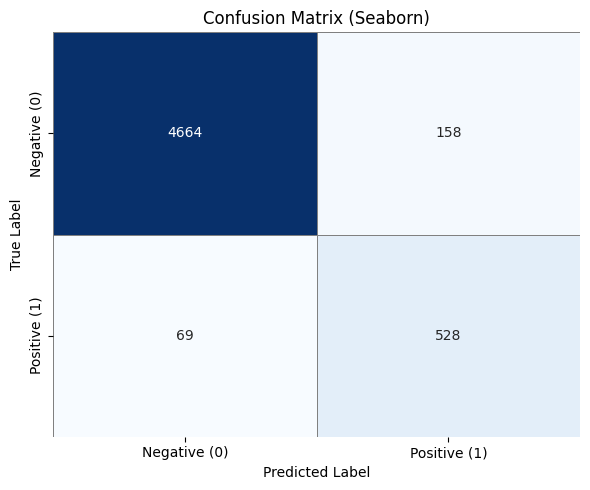

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_voting)
labels = ['Negative (0)', 'Positive (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False)
plt.title("Confusion Matrix (Seaborn)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

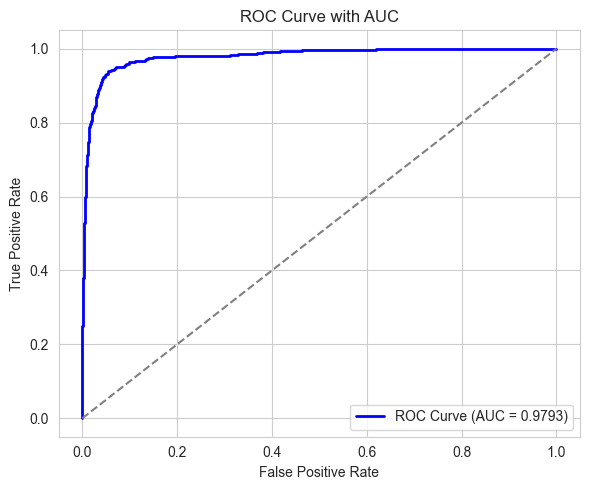

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba_voting)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with AUC")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [ ]:
df_res_voting = pd.DataFrame({
    'vopenid': vopenid_test,
    'true_label': y_test,
    'predicted_label': y_test_pred_voting,
    'proba': y_test_proba_voting
})

df_res_voting = df_res_voting.merge(df_merged, on='vopenid', how='left')
df_res_voting

,vopenid,true_label,predicted_label,proba,total_purchase,num_purchase,max_purchase,avg_purchase,frequency_purchase,count_purchase_on_day,std_amount_purchase,days_since_last_purchase,num_product_buyed,num_login,num_day_login,login_frequency,avg_weekly_login,std_weekly_login,streak_login,days_since_last_login,gold_std_login,diamond_std_login,silkcoin_std_login,short_lifetime_flag,powerpoint_last_login,vip_last_login,churn,equi_beha
0,2411262251518655,0,0,0.00,71.91,9,19.99,7.99,1.29,1.29,5.74,0,5,812,48,16.92,116.00,37.32,48,6,132586015.23,25.06,610.46,0,42634663,3,0,c
1,2506112328080104,0,0,0.08,6.31,3,3.94,2.10,1.50,1.50,1.64,0,3,24,8,3.00,12.00,5.00,5,7,599497.87,0.00,14.45,0,1314808,2,0,a
2,2505112333129412,0,0,0.01,31.51,3,15.75,10.50,1.50,1.50,4.54,15,2,83,36,2.31,13.83,5.89,12,7,6739540.56,157.23,408.60,0,3402020,3,0,a
3,2506111832342152,0,0,0.01,22.50,2,15.00,11.25,2.00,2.00,5.30,11,2,17,6,2.83,17.00,1.50,6,7,819752.10,150.11,226.71,0,641266,3,0,not_enhance
4,2504090745344821,0,0,0.03,21.38,4,7.88,5.34,2.00,2.00,2.71,45,3,440,47,9.36,62.86,35.62,42,7,12695683.47,91.88,392.23,0,15135178,0,0,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5414,2503131708350272,0,0,0.00,39.39,4,15.75,9.85,1.00,1.00,3.94,3,3,242,47,5.15,34.57,12.48,47,7,2170162.64,189.32,185.22,0,10983465,0,0,a
5415,2506130357135743,0,0,0.01,23.63,2,15.75,11.81,2.00,2.00,5.56,12,2,16,8,2.00,8.00,3.00,8,7,892935.26,165.65,50.86,0,818005,3,0,not_enhance
5416,2411141629144477,0,0,0.02,15.75,1,15.75,15.75,1.00,1.00,0.00,28,1,31,17,1.82,7.75,3.87,8,7,1082313.98,274.26,88.78,0,10291935,0,0,not_enhance
5417,2506110054314534,0,0,0.01,89.94,6,19.99,14.99,3.00,3.00,5.48,9,2,65,9,7.22,32.50,2.50,9,7,577069.42,189.57,134.47,0,353781,3,0,not_enhance


#### **Stacking Classifier**

In [ ]:
stacking_model = StackingClassifier(
    estimators=[
        ('lr',lr_model),
        ('et', et_model),
        ('rf', rf_model),
        #('svc',svc_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('cb',cb_model),
    ],
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=5,
    n_jobs=-1
)
    
stacking_model.fit(X_train,y_train)

StackingClassifier(cv=5,
                   estimators=[('lr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('logisticregression',
                                                 LogisticRegression(C=6.132071099192554,
                                                                    n_jobs=-1,
                                                                    penalty='l1',
                                                                    random_state=42,
                                                                    solver='liblinear'))])),
                               ('et',
                                ExtraTreesClassifier(max_depth=21,
                                                     max_features=0.5,
                                                     n_estimators=349,
                                                     n_jobs=-1,
                                                     random_state=42)),
                               ('rf',
                                RandomForestClassifier(b...
                                               reg_lambda=0.18534635584392095,
                                               scale_pos_weight=10,
                                               subsample=0.6360078971851577)),
                               ('cb',
                                Pipeline(steps=[('functiontransformer',
                                                 FunctionTransformer(func=<function <lambda> at 0x0000022B7D64C0E0>)),
                                                ('catboostclassifier',
                                                 <catboost.core.CatBoostClassifier object at 0x0000022B7C77E540>)]))],
                   final_estimator=LogisticRegression(class_weight='balanced'),
                   n_jobs=-1)

In [ ]:
y_test_proba_stacking = stacking_model.predict_proba(X_test)[:, 1]
y_test_pred_stacking  = stacking_model.predict(X_test)

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_stacking):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_stacking):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_stacking):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred_stacking):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba_stacking):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba_stacking):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba_stacking):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred_stacking))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred_stacking))

Accuracy: 0.9600
Precision: 0.7978
Recall: 0.8526
F1-score: 0.8243
AUC-ROC: 0.9760
Log loss: 0.1248
Brier score: 0.0328

Confusion matrix:
[[4693  129]
 [  88  509]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4822
           1       0.80      0.85      0.82       597

    accuracy                           0.96      5419
   macro avg       0.89      0.91      0.90      5419
weighted avg       0.96      0.96      0.96      5419



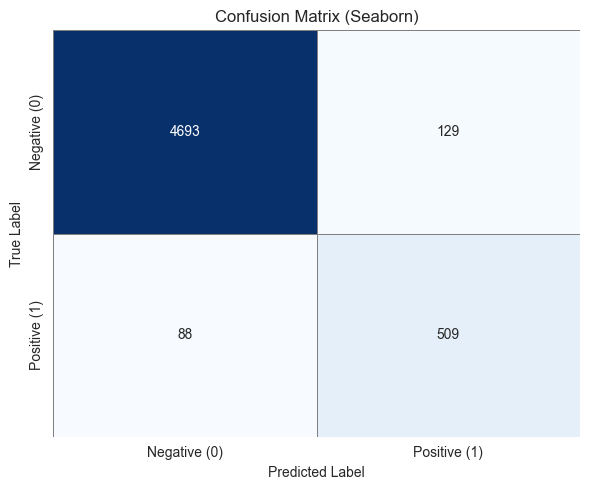

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_stacking)
labels = ['Negative (0)', 'Positive (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False)
plt.title("Confusion Matrix (Seaborn)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

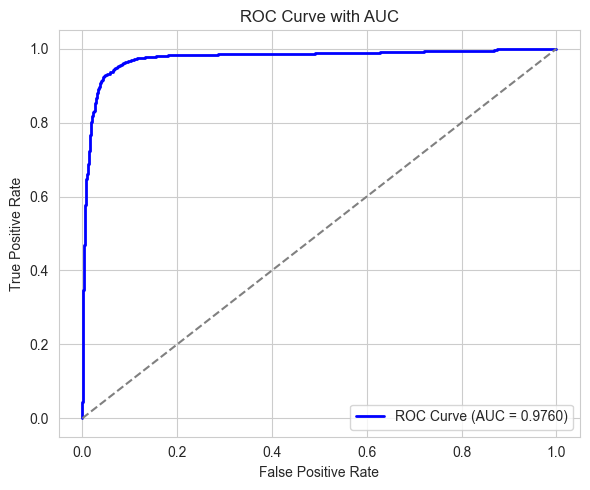

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba_stacking)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with AUC")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:
df_res_stacking = pd.DataFrame({
    'vopenid': vopenid_test,
    'true_label': y_test,
    'predicted_label': y_test_pred_stacking,
    'proba': y_test_proba_stacking
})

df_res_stacking = df_res_stacking.merge(df_merged, on='vopenid', how='left')
df_res_stacking

,vopenid,true_label,predicted_label,proba,total_purchase,num_purchase,max_purchase,avg_purchase,frequency_purchase,count_purchase_on_day,std_amount_purchase,days_since_last_purchase,num_product_buyed,num_login,num_day_login,login_frequency,avg_weekly_login,std_weekly_login,streak_login,days_since_last_login,gold_std_login,diamond_std_login,silkcoin_std_login,short_lifetime_flag,powerpoint_last_login,vip_last_login,churn,equi_beha
0,2411262251518655,0,0,0.00,71.91,9,19.99,7.99,1.29,1.29,5.74,0,5,812,48,16.92,116.00,37.32,48,6,132586015.23,25.06,610.46,0,42634663,3,0,c
1,2506112328080104,0,0,0.01,6.31,3,3.94,2.10,1.50,1.50,1.64,0,3,24,8,3.00,12.00,5.00,5,7,599497.87,0.00,14.45,0,1314808,2,0,a
2,2505112333129412,0,0,0.00,31.51,3,15.75,10.50,1.50,1.50,4.54,15,2,83,36,2.31,13.83,5.89,12,7,6739540.56,157.23,408.60,0,3402020,3,0,a
3,2506111832342152,0,0,0.00,22.50,2,15.00,11.25,2.00,2.00,5.30,11,2,17,6,2.83,17.00,1.50,6,7,819752.10,150.11,226.71,0,641266,3,0,not_enhance
4,2504090745344821,0,0,0.00,21.38,4,7.88,5.34,2.00,2.00,2.71,45,3,440,47,9.36,62.86,35.62,42,7,12695683.47,91.88,392.23,0,15135178,0,0,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5414,2503131708350272,0,0,0.00,39.39,4,15.75,9.85,1.00,1.00,3.94,3,3,242,47,5.15,34.57,12.48,47,7,2170162.64,189.32,185.22,0,10983465,0,0,a
5415,2506130357135743,0,0,0.00,23.63,2,15.75,11.81,2.00,2.00,5.56,12,2,16,8,2.00,8.00,3.00,8,7,892935.26,165.65,50.86,0,818005,3,0,not_enhance
5416,2411141629144477,0,0,0.00,15.75,1,15.75,15.75,1.00,1.00,0.00,28,1,31,17,1.82,7.75,3.87,8,7,1082313.98,274.26,88.78,0,10291935,0,0,not_enhance
5417,2506110054314534,0,0,0.00,89.94,6,19.99,14.99,3.00,3.00,5.48,9,2,65,9,7.22,32.50,2.50,9,7,577069.42,189.57,134.47,0,353781,3,0,not_enhance


In [ ]:
df_res_stacking.head(10)

,vopenid,true_label,predicted_label
0,2411262251518655,0,0
1,2506112328080104,0,0
2,2505112333129412,0,0
3,2506111832342152,0,0
4,2504090745344821,0,0
5,2506032104435467,0,0
6,2502231047068623,0,0
7,2506121236547954,0,0
8,2506151548512298,0,0
9,2505210934391578,0,1


In [ ]:
df_stack_false=df_res_stacking[(df_res_stacking['true_label']!=df_res_stacking['predicted_label']) & (df_res_stacking['total_purchase']>0)]

In [ ]:
df_stack_false[['vopenid','true_label','predicted_label','proba']].to_csv("check_p.csv",header=True,index=False)

In [ ]:
df_cluster_purchase=pd.read_csv("user_purchase_clusters.csv",dtype={"vopenid":"object"})
df_cluster_purchase.shape

(37219, 14)

In [ ]:
df_res_stacking=df_res_stacking[['vopenid','true_label','predicted_label']]
df_cluster_purchase = df_cluster_purchase.merge(df_res_stacking, on='vopenid', how='left')
df_cluster_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37219 entries, 0 to 37218
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   vopenid                   37219 non-null  object 
 1   last_update_time          37219 non-null  object 
 2   total_purchase            37219 non-null  float64
 3   num_purchase              37219 non-null  int64  
 4   max_purchase              37219 non-null  float64
 5   avg_purchase              37219 non-null  float64
 6   frequency_purchase        37219 non-null  float64
 7   count_purchase_on_day     37219 non-null  float64
 8   std_amount_purchase       37219 non-null  float64
 9   days_since_last_purchase  37219 non-null  int64  
 10  kmeans_cluster            37219 non-null  int64  
 11  pca_kmean_1               37219 non-null  float64
 12  pca_kmean_2               37219 non-null  float64
 13  name_cluster              37219 non-null  object 
 14  true_l